# Sentiment prediction from Amazon reviews
## About DataSet
 This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
## Contents
 - **database.csv :** Contains the table 'Reviews'
 - **Reviews.csv :** Pulled from the corresponding SQLite table named Reviews in database.sqlite
## Data includes:
 - Reviews from Oct 1999 - Oct 2012
 - 568,454 reviews
 - 256,059 users
 - 74,258 products
 - 260 users with > 50 reviews

In [1]:
import sys
import os

# Getting the current script's directory
current_dir = os.getcwd()

# Adding the parent directory to the Python path
sys.path.append(os.path.dirname(current_dir))

In [2]:
#Importing Libraries

import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle
import gensim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_preprocessing import clean_text, preprocess_text, sentence_to_words
from ml_algorithms.KNN import KNN_train_simple_cv
from ml_algorithms.NaiveBayes import NaiveBayes_train_simple_cv
from ml_algorithms.SGDClassifier import SGDClassifier_train_random_search_cv
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
raw_data = pd.read_csv("C:\Anand\Projects_GWU\Sentiment-prediction-from-Amazon-reviews\data\Reviews.csv")

In [4]:
raw_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [5]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [6]:
# Just for faster computation use first 50000 rows 
# ************************************Remove Later********************************************
raw_data = raw_data[:250000]
# ********************************************************************************************

In [7]:
raw_data.shape

(250000, 10)

In [8]:
# Drop rows with rating/score as 3.
value_to_drop = 3

# Drop rows where 'Score' has value 3.
raw_data = raw_data[raw_data['Score'] != value_to_drop]

In [9]:
# After dropping row with score 3
print(raw_data.shape)

#Unique values in Score column must be 1/2/4/5.
print(raw_data.Score.unique())

(230478, 10)
[5 1 4 2]


In [10]:
# Giving 4&5 as Positive and 1&2 as Negative Rating 
def assign_values(value):
    if value < 3:
        return 'Negative'
    else:
        return 'Positive'

raw_data['Review'] = raw_data['Score'].apply(assign_values)

In [11]:
raw_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [12]:
# Checking for duplicate Reviews 
boolean = not raw_data["Text"].is_unique      
boolean = raw_data['Text'].duplicated().any()
print(boolean)

True


In [13]:
# Drop duplicated Reviews
raw_data = raw_data.drop_duplicates(subset='Text', keep='first')

# Check the shape
print(raw_data.shape)

(182285, 11)


In [14]:
# Check if HelpfulnessNumerator is less than HelpfulnessDenominator, If so then drop those rows
raw_data=raw_data[raw_data.HelpfulnessNumerator<=raw_data.HelpfulnessDenominator]
print(raw_data.shape)

# The observations in the dataset dropped from 568454 to 363834 as there were a lot of Duplicate Reviews and Number of people who found review helpful cannot be greater than number of people who viewed the review. These rows were dropped

# # Check proportions of categories in output label:
# raw_data['Review'].value_counts()

(182283, 11)


In [15]:
# Apply clean_text function to clean the text column.
raw_data['Clean_Text'] = raw_data['Text'].apply(lambda x: clean_text(x))

In [16]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [17]:
# Apply text preprocessing to the 'Text' column from data-preprocessing.py file 
raw_data['Clean_Text'] = raw_data['Clean_Text'].apply(preprocess_text)

In [18]:
# Comparing the Original Text and the processed text
print(raw_data["Text"][1])

print("\n After Processing of Text \n")

print(raw_data["Clean_Text"][1])

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

 After Processing of Text 

product arriv label jumbo salt peanutsth peanut actual small size unsalt not sure error vendor intend repres product jumbo


In [19]:
# Converting sentence into words using sentence_to_words function from the data_preprocessing file
list_of_words_in_sentance = sentence_to_words(raw_data, 'Clean_Text')

In [20]:
raw_data["Clean_Text"].iloc[0]

'bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better'

In [21]:
print(raw_data['Clean_Text'])

0         bought sever vital can dog food product found ...
1         product arriv label jumbo salt peanutsth peanu...
2         this confect around centuri light pillowi citr...
3         look secret ingredi robitussin believ found go...
4         great taffi great price there wide assort yumm...
                                ...                        
249897    bought product great australian live difficult...
249898    yes pictur incorrect you get two pack singl pa...
249899    when purchas keep mind pictur dishonest mislea...
249900    what pictur show fun dip tripl pack come flavo...
249902    this far absolut best cake mix ever tri sinc g...
Name: Clean_Text, Length: 182283, dtype: object


In [22]:
print(f"Sentence cleaned: {raw_data['Clean_Text'].values[0]}")
print(f"Words in cleaned sentence{list_of_words_in_sentance[0]}")

Sentence cleaned: bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better
Words in cleaned sentence['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'the', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


 Time Based Splitting

In [23]:
final_reviews = raw_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(182283, 12)

In [24]:
# Label Encoding Reviews Column
label_encoder = LabelEncoder()

# Fit and transform the "Review" column
raw_data['Review'] = label_encoder.fit_transform(raw_data['Review'])

 Train and Test Split

In [25]:
# Splitting data into train, Train and Test 
X = raw_data['Clean_Text']
Y = raw_data['Review']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=123)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)

X_train, Y_train (145826,) (145826,)
X_test, Y_test (36457,) (36457,)


# Bag of Words

In [26]:
# Bag Of Words
Count_vectorizer = CountVectorizer()
X_train_bow = Count_vectorizer.fit_transform(X_train.values)
print(f"Shape of dataset after converting into BOW is {X_train_bow.get_shape()}")
X_test_bow = Count_vectorizer.transform(X_test.values)  # Use transform instead of fit_transform
print(f"Shape of dataset after converting into BOW is {X_test_bow.get_shape()}")

Shape of dataset after converting into BOW is (145826, 102749)
Shape of dataset after converting into BOW is (36457, 102749)


In [27]:
# Normalize BOW Train and Test Data
X_train_bow=preprocessing.normalize(X_train_bow)
X_test_bow=preprocessing.normalize(X_test_bow)
print("The shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("Test Data Size: ",X_test_bow.shape)

The shape of out text BOW vectorizer  (145826, 102749)
Test Data Size:  (36457, 102749)


# Uni, Bi and Tri Grams

In [28]:
Count_vectorizer_n_grams = CountVectorizer(ngram_range=(1,3) ) 
X_train_n_grams = Count_vectorizer_n_grams.fit_transform(X_train.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_train_n_grams.get_shape())
X_test_n_grams = Count_vectorizer_n_grams.transform(X_test.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_test_n_grams.get_shape())

Shape of dataset after converting into uni, bi and tri-grams is  (145826, 6311356)
Shape of dataset after converting into uni, bi and tri-grams is  (36457, 6311356)


# Tf-Idf Vectorization

In [29]:
# tf-idf Vectorizer
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tf_idf_vectorizer = tf_idf_vectorizer.fit_transform(X_train.values)
X_test_tf_idf_vectorizer = tf_idf_vectorizer.transform(X_test.values)

print("Shape of train dataset after converting into tf-idf is ", X_train_tf_idf_vectorizer.get_shape())
print("Shape of test dataset after converting into tf-idf is ", X_test_tf_idf_vectorizer.get_shape())

Shape of train dataset after converting into tf-idf is  (145826, 1817919)
Shape of test dataset after converting into tf-idf is  (36457, 1817919)


In [30]:
# Normalize Tf-Idf Train and Test Data
X_train_tfidf=preprocessing.normalize(X_train_tf_idf_vectorizer)
X_test_tfidf=preprocessing.normalize(X_test_tf_idf_vectorizer)
print("Train Data Size: ",X_train_tfidf.get_shape())
print("Test Data Size: ",X_test_tfidf.shape)

Train Data Size:  (145826, 1817919)
Test Data Size:  (36457, 1817919)


# word2vec Model
 Making word2vec model using our data set and the same model will be used further.

In [31]:
# Training word2vec model on our own data.
w2v_model=gensim.models.Word2Vec(list_of_words_in_sentance,min_count=5, workers=4) 

In [32]:
# Saving the vocabolary of words in our trained word2vec model
w2v_vocab = list(w2v_model.wv.key_to_index)

In [33]:
# Get the top 10 words most similar words to "quality"
w2v_model.wv.most_similar('good')

[('great', 0.7536801695823669),
 ('decent', 0.73526930809021),
 ('excel', 0.6393976211547852),
 ('awesom', 0.6263736486434937),
 ('bad', 0.5943878293037415),
 ('terrif', 0.5933353900909424),
 ('fantast', 0.5791688561439514),
 ('nice', 0.567089855670929),
 ('tasti', 0.5610722899436951),
 ('like', 0.5277270674705505)]

In [34]:
raw_data.shape[0]

182283

# Average word2vec

In [35]:
sent_vectors_avg_word2vec = []; # The avg-w2v for each sentence/review is stored in this list
vector_size = len(w2v_model.wv['good']) 

for sent in tqdm(list_of_words_in_sentance): # Iterating over each review/sentence
    sent_vec = np.zeros(vector_size) 
    cnt_words =0; 
    for word in sent: # Iterating over each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_avg_word2vec.append(sent_vec)
print(len(sent_vectors_avg_word2vec))

100%|██████████| 182283/182283 [02:39<00:00, 1146.39it/s]

182283


In [36]:
X_train_avg_wor2vec, X_test_avg_wor2vec, Y_train_avg_wor2vec, Y_test_avg_wor2vec = train_test_split(sent_vectors_avg_word2vec,Y, test_size=.20, random_state=0)
X_train_avg_wor2vec=preprocessing.normalize(X_train_avg_wor2vec)
X_test_avg_wor2vec=preprocessing.normalize(X_test_avg_wor2vec)
print(X_train_avg_wor2vec.shape)
print(X_test_avg_wor2vec.shape)

(145826, 100)
(36457, 100)


# Tf-Idf Word2vec

In [37]:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(raw_data['Clean_Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_words_in_sentance): # for each review/sentence 
    sent_vec = np.zeros(vector_size) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            #  tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train_tfidf_word2vec, X_test_tfidf_word2vec, Y_train_tfidf_wor2vec, Y_test_tfidf_wor2vec = train_test_split(tfidf_sent_vectors, Y, test_size=0.20,random_state=0)
X_train_tfidf_word2vec=preprocessing.normalize(X_train_tfidf_word2vec)
X_test_tfidf_word2vec=preprocessing.normalize(X_test_tfidf_word2vec)
print(X_train_tfidf_word2vec.shape)
print(X_test_tfidf_word2vec.shape)

100%|██████████| 182283/182283 [03:17<00:00, 922.76it/s] 


(145826, 100)
(36457, 100)


 KNN on Bag of Words

1 - AUC Score (CV): 0.532006661825148  Accuracy (CV): 0.8325125200008312
3 - AUC Score (CV): 0.643451093569311  Accuracy (CV): 0.8403050516385097
5 - AUC Score (CV): 0.725266866599416  Accuracy (CV): 0.8510275751719552
7 - AUC Score (CV): 0.7594325159562544  Accuracy (CV): 0.8528146624275295
9 - AUC Score (CV): 0.7784850273566114  Accuracy (CV): 0.8535004052116452
11 - AUC Score (CV): 0.7917764950241452  Accuracy (CV): 0.8549134509486108
13 - AUC Score (CV): 0.7992726687087726  Accuracy (CV): 0.8546225297674709
15 - AUC Score (CV): 0.8057551292978132  Accuracy (CV): 0.855225152214118
17 - AUC Score (CV): 0.8123067515074274  Accuracy (CV): 0.8546640899362051
19 - AUC Score (CV): 0.8172304943472747  Accuracy (CV): 0.8547264301893066
21 - AUC Score (CV): 0.8209803984605099  Accuracy (CV): 0.8549965712860794
23 - AUC Score (CV): 0.8243233473148418  Accuracy (CV): 0.8547679903580409
Best k-value based on AUC: 23
Best accuracy: 0.855225152214118


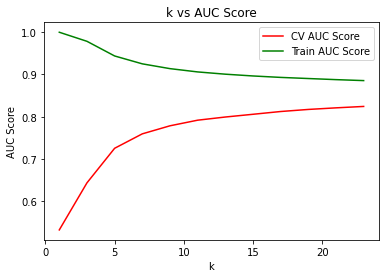

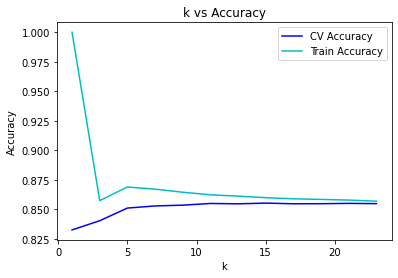

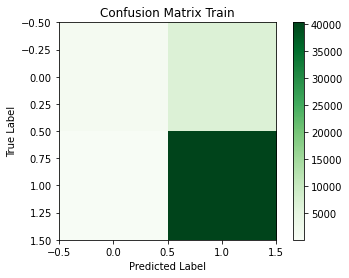

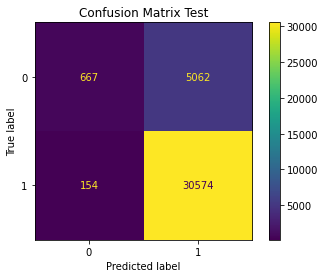

158788    1
111053    1
86185     1
59085     1
124796    1
         ..
2480      0
216585    0
211529    1
9532      1
61789     1
Name: Review, Length: 36457, dtype: int32 

[0.91304348 1.         1.         ... 0.82608696 0.95652174 0.95652174] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8322527745740999
Accuracy (Test): 0.8569273390569713


In [38]:
auc_score_bow_test_KNN, accuracy_bow_test_KNN = KNN_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 KNN on tf-idf

1 - AUC Score (CV): 0.5035481505820987  Accuracy (CV): 0.8427363215094653
3 - AUC Score (CV): 0.6307698594817743  Accuracy (CV): 0.8417804376285768
5 - AUC Score (CV): 0.7080331006783646  Accuracy (CV): 0.8508821145813852
7 - AUC Score (CV): 0.7440971378379984  Accuracy (CV): 0.8539783471520894
9 - AUC Score (CV): 0.767309691062647  Accuracy (CV): 0.855225152214118
11 - AUC Score (CV): 0.7821994124519241  Accuracy (CV): 0.8557238742389294
13 - AUC Score (CV): 0.7952291363929963  Accuracy (CV): 0.8560355755044365
15 - AUC Score (CV): 0.8024170400025487  Accuracy (CV): 0.8561394759262723
17 - AUC Score (CV): 0.8093558843232438  Accuracy (CV): 0.8560771356731708
19 - AUC Score (CV): 0.8154041151958235  Accuracy (CV): 0.8559940153357023
21 - AUC Score (CV): 0.8213704368148916  Accuracy (CV): 0.8558693348294995
23 - AUC Score (CV): 0.8251657184179947  Accuracy (CV): 0.8554329530577894
Best k-value based on AUC: 23
Best accuracy: 0.8561394759262723


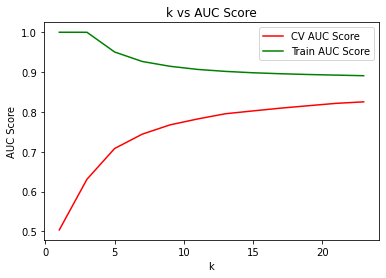

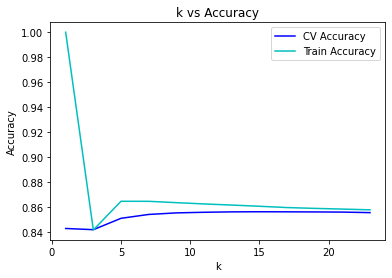

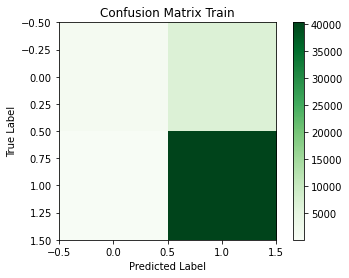

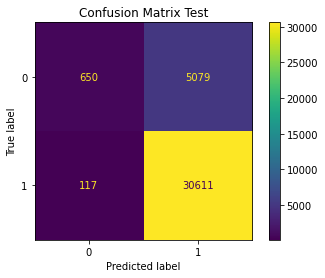

158788    1
111053    1
86185     1
59085     1
124796    1
         ..
2480      0
216585    0
211529    1
9532      1
61789     1
Name: Review, Length: 36457, dtype: int32 

[0.73913043 0.95652174 0.91304348 ... 0.86956522 0.95652174 0.91304348] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8340207178893938
Accuracy (Test): 0.8574759305483172


In [39]:
auc_score_tf_idf_test_KNN, accuracy_tf_idf_test_KNN = KNN_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 KNN on Tf-Idf word2vec

1 - AUC Score (CV): 0.6697676428765391  Accuracy (CV): 0.824616087941317
3 - AUC Score (CV): 0.7599045850001178  Accuracy (CV): 0.8559940153357023
5 - AUC Score (CV): 0.7937195804064338  Accuracy (CV): 0.8655320740602207
7 - AUC Score (CV): 0.8105057721831281  Accuracy (CV): 0.8691893689088378
9 - AUC Score (CV): 0.8209090551154061  Accuracy (CV): 0.8707894354051078
11 - AUC Score (CV): 0.8289948114312905  Accuracy (CV): 0.8720154603827691
13 - AUC Score (CV): 0.8353210727386686  Accuracy (CV): 0.8720570205515035
15 - AUC Score (CV): 0.8388415622208556  Accuracy (CV): 0.8720362404671363
17 - AUC Score (CV): 0.8415687314366614  Accuracy (CV): 0.8717037591172621
19 - AUC Score (CV): 0.8442116129740433  Accuracy (CV): 0.8715998586954263
21 - AUC Score (CV): 0.8459543349328597  Accuracy (CV): 0.8713920578517549
23 - AUC Score (CV): 0.8485245988229295  Accuracy (CV): 0.8714751781892235
Best k-value based on AUC: 23
Best accuracy: 0.8720570205515035


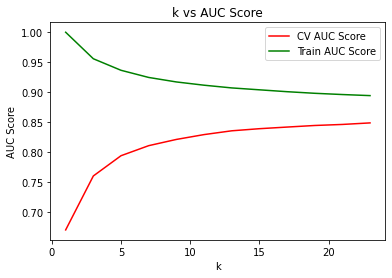

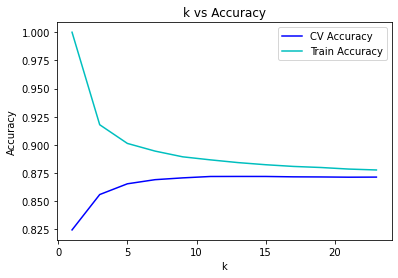

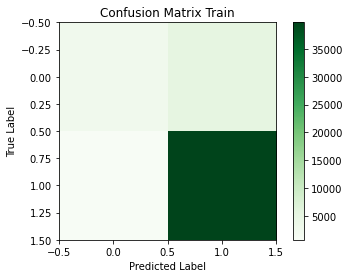

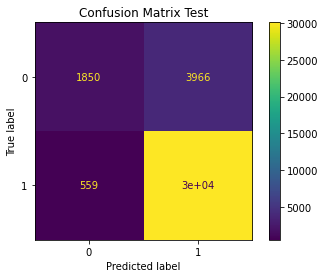

26688     0
182864    1
107670    1
215869    1
79918     1
         ..
240596    1
70876     1
34789     1
33988     1
23453     1
Name: Review, Length: 36457, dtype: int32 

[0.56521739 1.         0.82608696 ... 1.         1.         1.        ] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8589708565139166
Accuracy (Test): 0.8758811750829745


In [40]:
auc_score_word2vec_test_KNN, accuracy_bword2vec_test_KNN = KNN_train_simple_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

In [41]:
# Naive Bayes from here

 NaiveBayes on Bag of Words

AUC Score (CV): 0.8623449571371984  Accuracy (CV): 0.8416765372067411
AUC Score (Train): 0.8783855946603158  Accuracy (Train): 0.8403324360562112


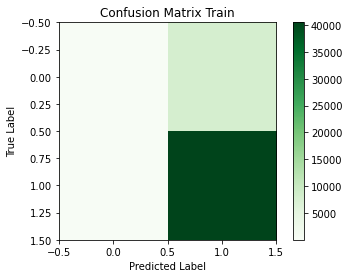

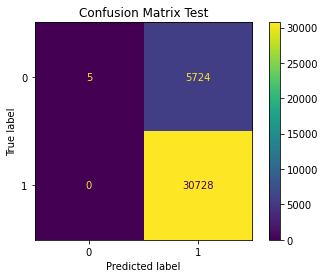

AUC Score (Test): 0.8619536258181004
Accuracy (Test): 0.8429931151767837


In [42]:
auc_score_bow_test_NB, accuracy_bow_test_NB = NaiveBayes_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 NaiveBayes on tf-idf

AUC Score (CV): 0.8118751549298404  Accuracy (CV): 0.8416973172911082
AUC Score (Train): 0.9118889097738155  Accuracy (Train): 0.8404552572592449


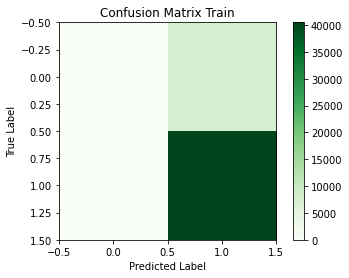

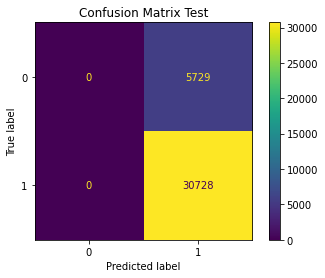

AUC Score (Test): 0.7977412974789604
Accuracy (Test): 0.8428559673039471


In [43]:
auc_score_tf_idf_test_NB, accuracy_tf_idf_test_NB = NaiveBayes_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 NaiveBayes on Tf-Idf word2vec

In [44]:
# auc_score_tfidf_word2vec_test_NB, accuracy_tfidf_word2vec_test_NB = NaiveBayes_train_simple_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

In [45]:
# SGD Classifier from here

 SGD Classifier on Bag of Words

Best Hyperparameters: {'alpha': 1.9211659757411964e-06, 'eta0': 0.01}
AUC Score (CV): 0.946074809857396  Accuracy (CV): 0.920827878561187
AUC Score (Train): 0.9660827991972754  Accuracy (Train): 0.9362148552245069


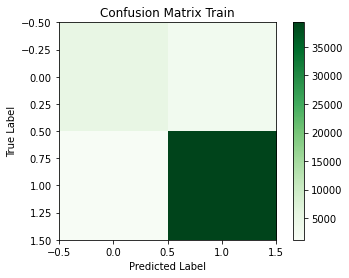

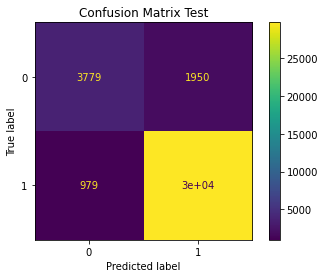

158788    1
111053    1
86185     1
59085     1
124796    1
         ..
2480      0
216585    0
211529    1
9532      1
61789     1
Name: Review, Length: 36457, dtype: int32 

[0.99498252 0.997351   0.99280129 ... 0.95349549 0.98203647 0.80713302] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.9464616514389012
Accuracy (Test): 0.9196587760923828


In [46]:
auc_score_bow_test_SGDC, accuracy_bow_test_SGDC = SGDClassifier_train_random_search_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 SGD Classifier on tf-idf

Best Hyperparameters: {'alpha': 1.9211659757411964e-06, 'eta0': 0.01}
AUC Score (CV): 0.9582384628250535  Accuracy (CV): 0.9266463021839869
AUC Score (Train): 0.9995024371625396  Accuracy (Train): 0.9932857742341586


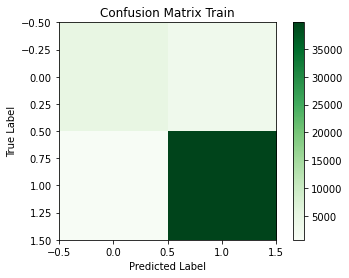

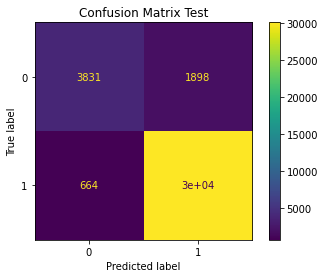

158788    1
111053    1
86185     1
59085     1
124796    1
         ..
2480      0
216585    0
211529    1
9532      1
61789     1
Name: Review, Length: 36457, dtype: int32 

[0.99078259 0.99775195 0.98546988 ... 0.99320446 0.98979711 0.85710287] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.9593659448503026
Accuracy (Test): 0.9297254299585813


In [47]:
auc_score_tf_idf_test_SGDC, accuracy_tf_idf_test_SGDC = SGDClassifier_train_random_search_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 SGD Classifier on Tf-Idf word2vec

Best Hyperparameters: {'alpha': 8.264328927007723e-05, 'eta0': 0.2}
AUC Score (CV): 0.898598635319009  Accuracy (CV): 0.8855017351370447
AUC Score (Train): 0.9014496946423861  Accuracy (Train): 0.887372956818112


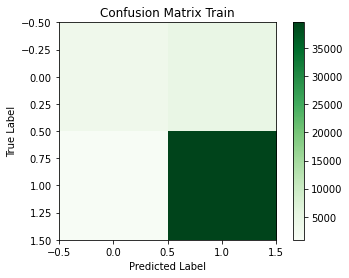

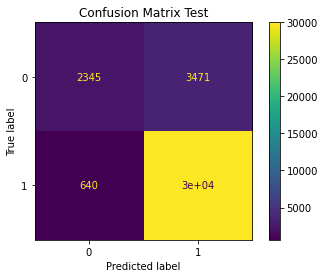

26688     0
182864    1
107670    1
215869    1
79918     1
         ..
240596    1
70876     1
34789     1
33988     1
23453     1
Name: Review, Length: 36457, dtype: int32 

[0.22664315 0.92840207 0.88764903 ... 0.99937233 0.98631626 0.98944726] 

[0 1 1 ... 1 1 1] 

AUC Score (Test): 0.9019865914479197
Accuracy (Test): 0.887237018953836


In [48]:
auc_score_tfidf_word2vec_test_SGDC, accuracy_tfidf_word2vec_test_SGDC = SGDClassifier_train_random_search_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

# KNN, Naive Bayes, and SGD Completed